In [39]:
import numpy as np, os, sys
sys.path.append("..")
import pandas as pd
import subprocess

import torch
from torch import nn
from torch.nn import functional as F 

from src.utils.synthetic_seqdata import download_data, load_data, sequence_string_to_one_hot
from src.models import DeepBindCNN
from src.trainer import Trainer
from src.utils.datasets import DNASequenceDataset
from sklearn.metrics import roc_auc_score, roc_curve
from src.utils import metrics
from src.explain import Explainer

import logomaker
from logomaker import Logo

import matplotlib as mpl 
from matplotlib import pyplot as plt 
import seaborn as sns 
%matplotlib inline

In [3]:
# get data 
savedir = "./data"
_=download_data(savedir)
Xs, Ys = load_data(savedir=savedir)
len(Xs['train']), Ys, len(Ys['train']), len(Ys['valid']), len(Ys['test'])

--2023-08-01 13:16:56--  https://www.dropbox.com/s/drnyowfdv1lbjz6/train_sequences.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/drnyowfdv1lbjz6/train_sequences.txt [following]
--2023-08-01 13:16:57--  https://www.dropbox.com/s/raw/drnyowfdv1lbjz6/train_sequences.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc27e522e2fdc992dc60de4e13d9.dl.dropboxusercontent.com/cd/0/inline/CA-uzS5ia1H_8IiR1YtTfHQqWEgmEIV6LWWYXydVI3vC8OCxtHYFec0eGz1XQEZZ1ygv-5fsJH9cuIif2npyu8dOwWj2hmYu98a5KS9y0fPu715jC88B1cZVc0jtSpJWm9k/file# [following]
--2023-08-01 13:16:58--  https://uc27e522e2fdc992dc60de4e13d9.dl.dropboxusercontent.com/cd/0/inline/CA-uzS5ia1H_8IiR1YtTfHQqWEgmEIV6LWWYXydVI3vC8OCxtHYFec0eGz1XQEZZ1ygv-5fsJH9cuIif2npyu8dOwWj2hmYu98a5KS

(14000,
 {'train': array([1., 1., 0., ..., 1., 0., 1.], dtype=float32),
  'valid': array([0., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'test': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)},
 14000,
 2000,
 4000)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "architecture": "deepbind",
    "dataset": "synthetic data",
    "epochs": 35,
    "patience": 3,
    }

In [17]:
# set up datasets
datasets = {}
for k in Xs:
    datasets[k] = DNASequenceDataset(sequences=Xs[k], labels=Ys[k], alphabet="ACGT")

# set up dataloaders 
loaders = {}
for k, dataset in datasets.items():
    if k == 'train':
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    else:
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'])
    
# set up the model, lossfn, optimizer, trainer 
model = DeepBindCNN(input_size=4, output_size=1, kernel_size=9)
lossfn = nn.CrossEntropyLoss()

model.load_state_dict(torch.load('best_model.pt'))
print(model)

DeepBindCNN(
  (conv1): Conv1d(4, 16, kernel_size=(9,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [18]:
# model 
# model.load_state_dict(torch.load("best_model.pt"))

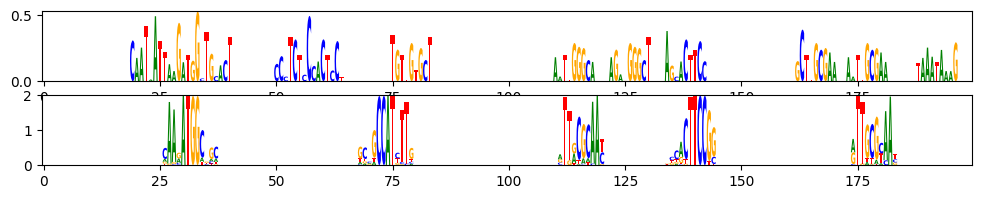

In [46]:
explainer = Explainer(model)

# load ground truth
gt_test = np.load("gt_test.npy",)

df = pd.DataFrame(I*w, columns=list("ACGT"))

# Select a random sample from the test dataset
sample_index = np.random.randint(len(datasets['test']))
input_sequence, target_label = datasets['test'][sample_index]
saliency_scores = explainer.saliency_map(input_sequence.unsqueeze(0))
saliency_scores = saliency_scores.abs().detach().cpu().numpy()[0].T
df = pd.DataFrame(saliency_scores, columns=list("ACGT"))

# visualize saliency scores 
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot(211)
_= Logo(df, ax=ax)

# calculate gt information 
w = gt_test[sample_index].T
I  = np.log2(4) + np.sum(w * np.log2(w+1e-10), axis=1, keepdims=True)

# visualize the gt information
df = pd.DataFrame(I*w, columns=list("ACGT"))
ax = fig.add_subplot(212)
_= Logo(df, ax=ax)

,A,C,G,T
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
195,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0


In [19]:
explainer = Explainer(model)
saliency_scores = []
for inputs, labels in loaders['test']:
    inputs, labels = inputs.to(device), labels.to(device)
    saliency_scores.append(explainer.saliency_map(inputs))

In [16]:
len(saliency_scores)
(saliency_scores[0])

tensor([[[ 0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000],
         [ 0.0359, -0.0000,  0.0000,  ...,  0.0000, -0.0000,  0.0000],
         [-0.0000,  0.0137, -0.0000,  ..., -0.0000,  0.0317, -0.0000],
         [-0.0000,  0.0000, -0.0284,  ..., -0.0861,  0.0000, -0.0388]],

        [[ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0449, -0.0907],
         [ 0.0000, -0.0083, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0277, -0.0000, -0.0022,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000,  0.0000, -0.0000,  ..., -0.1491,  0.0000,  0.0000]],

        [[-0.0000, -0.0000,  0.0000,  ...,  0.0000, -0.0219, -0.0000],
         [ 0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000,  0.0000],
         [-0.0882,  0.0235,  0.0000,  ...,  0.0000, -0.0000,  0.0008],
         [-0.0000,  0.0000,  0.0008,  ..., -0.0830,  0.0000, -0.0000]],

        ...,

        [[-0.0086,  0.0000, -0.0000,  ..., -0.0838, -0.0098,  0.0000],
         [-0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.00

In [12]:
explainer = Explainer(model)
saliency_scores = []
for inputs, labels in loaders['test']:
    inputs, labels = inputs.to(device), labels.to(device)
    saliency_scores.append(explainer.smoothgrad(inputs))
print(saliency_scores[0])

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [50, 32, 4, 200]

In [6]:
explainer = Explainer(model)
saliency_scores = []
for inputs, labels in loaders['test']:
    inputs, labels = inputs.to(device), labels.to(device)
    saliency_scores.append(explainer.integrated_gradients(inputs))


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [50, 32, 4, 200]